<a href="https://colab.research.google.com/github/seismosmsr/machine_learning/blob/main/conditional_gan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Conditional GAN
**Author:** [Aron Boettcher](spectral.online)<br>
**Adapted from:** [Sayak Paul](https://twitter.com/RisingSayak)<br>
**Date created:** 2021/07/13<br>
**Last modified:** 2021/07/15<br>
**Description:** Training a GAN conditioned on class labels to generate handwritten digits.

Generative Adversarial Networks (GANs) let us generate novel image data, video data,
or audio data from a random input. Typically, the random input is sampled
from a normal distribution, before going through a series of transformations that turn
it into something plausible (image, video, audio, etc.).

However, a simple [DCGAN](https://arxiv.org/abs/1511.06434) doesn't let us control
the appearance (e.g. class) of the samples we're generating. For instance,
with a GAN that generates MNIST handwritten digits, a simple DCGAN wouldn't let us
choose the class of digits we're generating.
To be able to control what we generate, we need to _condition_ the GAN output
on a semantic input, such as the class of an image.

In this example, we'll build a **Conditional GAN** that can generate MNIST handwritten
digits conditioned on a given class. Such a model can have various useful applications:

* let's say you are dealing with an
[imbalanced image dataset](https://developers.google.com/machine-learning/data-prep/construct/sampling-splitting/imbalanced-data),
and you'd like to gather more examples for the skewed class to balance the dataset.
Data collection can be a costly process on its own. You could instead train a Conditional GAN and use
it to generate novel images for the class that needs balancing.
* Since the generator learns to associate the generated samples with the class labels,
its representations can also be used for [other downstream tasks](https://arxiv.org/abs/1809.11096).

Following are the references used for developing this example:

* [Conditional Generative Adversarial Nets](https://arxiv.org/abs/1411.1784)
* [Lecture on Conditional Generation from Coursera](https://www.coursera.org/lecture/build-basic-generative-adversarial-networks-gans/conditional-generation-inputs-2OPrG)

If you need a refresher on GANs, you can refer to the "Generative adversarial networks"
section of
[this resource](https://livebook.manning.com/book/deep-learning-with-python-second-edition/chapter-12/r-3/232).

This example requires TensorFlow 2.5 or higher, as well as TensorFlow Docs, which can be
installed using the following command:

In [1]:
!pip install -q git+https://github.com/tensorflow/docs

## Imports

In [2]:
from tensorflow import keras
from tensorflow.keras import layers

from tensorflow_docs.vis import embed
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import imageio

## Constants and hyperparameters

In [3]:
batch_size = 256
num_channels = 1
num_classes = 101
image_size = 512
latent_dim = 512

## Loading the MNIST dataset and preprocessing it

In [4]:
!pip install gdown
import gdown
import zipfile
import os

# I switched to pngs and jpgs to try and use tensorflows native vectorization
#todo: get gdal working so you can just use geotiff
url = 'https://drive.google.com/uc?id=1kwU_CkP1X5M1CDlYKPkb9p5J8GulWBXr'
output = 'sample_test.csv'

#Update with proper validation data
# https://drive.google.com/file/d/1unLB1XCJHoul3gqGYGzqSS8QMr5ZvJ9h/view?usp=sharing
gdown.download(url,output,quiet = False)

url = 'https://drive.google.com/uc?id=1graojPHaMvZGHmocsUFLds9bFWQG_mr6'
output = 'sample_train.csv'

#Update with proper validation data
# https://drive.google.com/file/d/1unLB1XCJHoul3gqGYGzqSS8QMr5ZvJ9h/view?usp=sharing
gdown.download(url,output,quiet = False)
# cwd = os.getcwd()
# with zipfile.ZipFile(cwd+'/sample.zip', 'r') as zip_ref:
#     zip_ref.extractall(cwd+'/sample')

# PATH = os.path.join(os.path.dirname(cwd+'/sample/'), 'sample/')
# print(PATH)

Downloading...
From: https://drive.google.com/uc?id=1kwU_CkP1X5M1CDlYKPkb9p5J8GulWBXr
To: /content/sample_test.csv
100%|██████████| 195M/195M [00:01<00:00, 145MB/s]
Downloading...
From: https://drive.google.com/uc?id=1graojPHaMvZGHmocsUFLds9bFWQG_mr6
To: /content/sample_train.csv
100%|██████████| 1.75G/1.75G [00:11<00:00, 156MB/s]


'sample_train.csv'

In [109]:
# generate n real samples with class labels
def generate_real_samples(s,filename = '/content/sample.csv'):
  import random
  import pandas
  import numpy
	# Sample s rows of data.frame

  #number of records in file (excludes header)
  n = sum(1 for line in open(filename)) - 1 

  #the 0-indexed header will not be included in the skip list
  skip = sorted(random.sample(range(1,n+1),n-s)) 
  df = pandas.read_csv(filename, skiprows=skip)
  X = []
  for i in range(len(df.index)):
    text_exa = df['rh'][i]
    text_exa = str(text_exa).replace("{","").replace("}", "")
    test_exa = text_exa.split(",")
    test_exa = [float(i) for i in test_exa]
    # test_exa = test_exa
    X.append(test_exa)


	# generate class labels
  y = []
  for i in range(len(df.index)):
    # y_one = numpy.ones(1)
    y_one = df['ls'][i]
    y_one = str(y_one).replace("{","").replace("}", "")
    y_one = y_one.split(",")
    y_one = [float(i) for i in y_one]
    y.append(y_one)

    
  X = numpy.array(X)
  y = numpy.array(y)

  X = (X.astype("float32") / 65455.0).astype("float32")
  y =(y.astype("float32")+100)/255
  return X, y

In [6]:
# generate_real_samples(2)

In [ ]:
import numpy as np
import tensorflow as tf

# We'll use all the available examples from both the training and test
# sets.
# (x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
(x_train, y_train) = generate_real_samples(450000,filename = '/content/sample_train.csv')
(x_test, y_test) = generate_real_samples(2000,filename = '/content/sample_test.csv')

# all_pixels = x_train
# all_labels = np.concatenate([y_train, y_test])

# # Scale based on reflectence values:
# # https://developers.google.com/earth-engine/datasets/catalog/LANDSAT_LC08_C02_T1_L2?hl=en#bands
# x_train = (x_train.astype("float32") / 65455.0).astype("float32")
# all_labels =(y_train.astype("float32")+100)/255

# x_test = (x_test.astype("float32") / 65455.0).astype("float32")
# y_test =(y_test.astype("float32")+100)/255
# # Create tf.data.Dataset.
dataset_train = tf.data.Dataset.from_tensor_slices((y_train,x_train))
dataset_train = dataset_train.shuffle(buffer_size=1024).batch(batch_size)

dataset_test = tf.data.Dataset.from_tensor_slices((y_test,x_test))
dataset_test = dataset_test.shuffle(buffer_size=1024).batch(batch_size)

# print(f"Shape of training images: {all_labels[1]}")
# print(f"Shape of training images: {all_pixels.shape}")
# print(f"Shape of training labels: {all_labels.shape}")

In [116]:
print(x_train[1])

[-8.15827661e-05 -7.59300237e-05 -7.01245153e-05 -6.44717729e-05
 -5.98884726e-05 -5.53051686e-05 -5.13329760e-05 -4.73607797e-05
 -4.38469142e-05 -4.04858329e-05 -3.71247443e-05 -3.42219864e-05
 -3.13192249e-05 -2.90275766e-05 -2.67359246e-05 -2.44442745e-05
 -2.21526243e-05 -1.98609723e-05 -1.75693222e-05 -1.58887779e-05
 -1.35971277e-05 -1.19165834e-05 -1.02360400e-05 -8.55549661e-06
 -6.26384553e-06 -4.43052477e-06 -2.74998092e-06 -1.06943708e-06
  4.58330135e-07  2.13887415e-06  4.43052477e-06  6.26384553e-06
  7.94438893e-06  9.62493323e-06  1.13054775e-05  1.35971277e-05
  1.52776720e-05  1.71109932e-05  1.94026434e-05  2.10831877e-05
  2.33748378e-05  2.50553821e-05  2.73470323e-05  2.90275766e-05
  3.13192249e-05  3.29997711e-05  3.52914212e-05  3.71247443e-05
  3.94163908e-05  4.10969369e-05  4.33885871e-05  4.50691332e-05
  4.67496757e-05  4.90413258e-05  5.07218683e-05  5.25551914e-05
  5.42357338e-05  5.65273876e-05  5.82079265e-05  5.98884726e-05
  6.21801228e-05  6.38606

## Calculating the number of input channel for the generator and discriminator

In a regular (unconditional) GAN, we start by sampling noise (of some fixed
dimension) from a normal distribution. In our case, we also need to account
for the class labels. We will have to add the number of classes to
the input channels of the generator (noise input) as well as the discriminator
(generated image input).

In [103]:
generator_in_channels = latent_dim + image_size
discriminator_in_channels = image_size + num_classes
print(generator_in_channels, discriminator_in_channels)

1024 613


## Creating the discriminator and generator

The model definitions (`discriminator`, `generator`, and `ConditionalGAN`) have been
adapted from [this example](https://keras.io/guides/customizing_what_happens_in_fit/).

In [112]:
# Create the discriminator.
discriminator = keras.Sequential(
    [
        keras.layers.InputLayer((discriminator_in_channels,)),
        layers.Dense(512),
        layers.LeakyReLU(alpha=0.2),
        layers.Dense(256),
        layers.LeakyReLU(alpha=0.2),
        layers.Dense(128),
        layers.LeakyReLU(alpha=0.2),
        layers.Dense(1),
    ],
    name="discriminator",
)

# Create the generator.
generator = keras.Sequential(
    [
        keras.layers.InputLayer((generator_in_channels,)),
        layers.Dense(1024),
        layers.LeakyReLU(alpha=0.2),
        layers.Dense(512),
        layers.LeakyReLU(alpha=0.2),
        layers.Dense(256),
        layers.LeakyReLU(alpha=0.2),
        layers.Dense(128),
        layers.LeakyReLU(alpha=0.2),
        layers.Dense(num_classes,  activation="linear"),
    ],
    name="generator",
)

## Creating a `ConditionalGAN` model

In [24]:

class ConditionalGAN(keras.Model):
  
    def __init__(self, discriminator, generator, latent_dim):
        super(ConditionalGAN, self).__init__()
        # Create the discriminator.
        discriminator = keras.Sequential(
            [
                keras.layers.InputLayer((discriminator_in_channels,)),
                layers.Dense(512),
                layers.LeakyReLU(alpha=0.2),
                layers.Dense(256),
                layers.LeakyReLU(alpha=0.2),
                layers.Dense(128),
                layers.LeakyReLU(alpha=0.2),
                layers.Dense(1),
            ],
            name="discriminator",
        )

        # Create the generator.
        generator = keras.Sequential(
            [
                keras.layers.InputLayer((generator_in_channels,)),
                layers.Dense(1024),
                layers.LeakyReLU(alpha=0.2),
                layers.Dense(512),
                layers.LeakyReLU(alpha=0.2),
                layers.Dense(256),
                layers.LeakyReLU(alpha=0.2),
                layers.Dense(128),
                layers.LeakyReLU(alpha=0.2),
                layers.Dense(num_classes,  activation="linear"),
            ],
            name="generator",
        )
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.gen_loss_tracker = keras.metrics.Mean(name="generator_loss")
        self.disc_loss_tracker = keras.metrics.Mean(name="discriminator_loss")

    @property
    def metrics(self):
        return [self.gen_loss_tracker, self.disc_loss_tracker]

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(ConditionalGAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn

    def train_step(self, data):
        # Unpack the data.
        real_pixels, real_labels = data
        # print(real_pixels[0])
        # Sample random points in the latent space and concatenate the labels.
        # This is for the generator.
        batch_size = tf.shape(real_pixels)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        # print(random_latent_vectors[0])
        random_vector_pixels = tf.concat(
            [random_latent_vectors, real_pixels], axis=1
        )
        # print(random_vector_pixels[0])
        # Decode the noise (guided by labels) to fake images.
        generated_labels = self.generator(random_vector_pixels)

        # Combine them with real images. Note that we are concatenating the labels
        # with these images here.
        fake_pixel_and_labels = tf.concat([generated_labels, real_pixels], -1)
        real_pixel_and_labels = tf.concat([real_labels, real_pixels], -1)
        combined_images = tf.concat(
            [fake_pixel_and_labels, real_pixel_and_labels], axis=0
        )

        # Assemble labels discriminating real from fake images.
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )

        # Train the discriminator.
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Sample random points in the latent space.
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        random_vector_labels = tf.concat(
            [random_latent_vectors, real_pixels], axis=1
        )

        # Assemble labels that say "all real images".
        misleading_labels = tf.zeros((batch_size, 1))

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            fake_labels = self.generator(random_vector_labels)
            fake_pixels_and_labels = tf.concat([real_pixels, fake_labels], -1)
            predictions = self.discriminator(fake_pixels_and_labels)
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Monitor loss.
        self.gen_loss_tracker.update_state(g_loss)
        self.disc_loss_tracker.update_state(d_loss)
        return {
            "g_loss": self.gen_loss_tracker.result(),
            "d_loss": self.disc_loss_tracker.result(),
        }


## Training the Conditional GAN

In [27]:
cond_gan = ConditionalGAN(
    discriminator=discriminator, generator=generator, latent_dim=latent_dim
)
cond_gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0000003),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0000003),
    loss_fn=keras.losses.BinaryCrossentropy(from_logits=True),
)

cond_gan.fit(dataset_train, epochs=50)

Epoch 1/50
782/782 [==============================] - 10s 5ms/step - g_loss: 0.6688 - d_loss: 0.6814
Epoch 2/50
782/782 [==============================] - 4s 5ms/step - g_loss: 0.6102 - d_loss: 0.6437
Epoch 3/50
782/782 [==============================] - 4s 5ms/step - g_loss: 0.5454 - d_loss: 0.5835
Epoch 4/50
782/782 [==============================] - 4s 5ms/step - g_loss: 0.4767 - d_loss: 0.5130
Epoch 5/50
782/782 [==============================] - 4s 5ms/step - g_loss: 0.4052 - d_loss: 0.4474
Epoch 6/50
782/782 [==============================] - 4s 5ms/step - g_loss: 0.3346 - d_loss: 0.3975
Epoch 7/50
782/782 [==============================] - 4s 5ms/step - g_loss: 0.2669 - d_loss: 0.3660
Epoch 8/50
782/782 [==============================] - 4s 6ms/step - g_loss: 0.2044 - d_loss: 0.3487
Epoch 9/50
782/782 [==============================] - 4s 5ms/step - g_loss: 0.1488 - d_loss: 0.3394
Epoch 10/50
782/782 [==============================] - 4s 5ms/step - g_loss: 0.1030 - d_loss: 0.334

## Interpolating between classes with the trained generator

In [145]:
from keras import Input
from keras.layers import Conv1D
from keras.layers import MaxPooling1D
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Dropout

from keras import Model
input_layer = Input(shape=(512))
dense1 = Dense(1024, activation='relu')(input_layer)
dense2 = Dense(1024, activation='relu')(dense1)
dropout1 =  Dropout(.5)(dense2)
resh1 = Reshape(target_shape=(1,16,64))(dropout1)
conv1 = Conv1D(filters=32,
               kernel_size=16,
               strides=1,
               activation='relu')(resh1)
resh1 = Reshape(target_shape=(32,1))(conv1)
pool1 = MaxPooling1D(pool_size=2)(resh1)
lstm1 = LSTM(32)(pool1)
output_layer = Dense(101, activation='linear')(lstm1)
model = Model(inputs=input_layer, outputs=output_layer)
optimizer = keras.optimizers.Adam(lr=0.000001)
model.compile(loss="MeanSquaredError", optimizer=optimizer)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [146]:
model.fit(dataset_train,validation_data =dataset_test , epochs=50)

Epoch 1/50
782/782 [==============================] - 9s 8ms/step - loss: 0.0123 - val_loss: 1.5040e-04
Epoch 2/50
782/782 [==============================] - 4s 6ms/step - loss: 0.0012 - val_loss: 8.6102e-05
Epoch 3/50
782/782 [==============================] - 4s 6ms/step - loss: 4.0218e-04 - val_loss: 4.9152e-05
Epoch 4/50
782/782 [==============================] - 4s 6ms/step - loss: 1.8675e-04 - val_loss: 1.0258e-05
Epoch 5/50
782/782 [==============================] - 5s 6ms/step - loss: 9.6211e-05 - val_loss: 1.0420e-05
Epoch 6/50
782/782 [==============================] - 5s 6ms/step - loss: 5.5994e-05 - val_loss: 1.0272e-05
Epoch 7/50
782/782 [==============================] - 4s 6ms/step - loss: 3.7140e-05 - val_loss: 8.8841e-06
Epoch 8/50
782/782 [==============================] - 5s 6ms/step - loss: 2.6400e-05 - val_loss: 6.6955e-06
Epoch 9/50
782/782 [==============================] - 4s 6ms/step - loss: 1.8221e-05 - val_loss: 4.3675e-06
Epoch 10/50
782/782 [===============

In [126]:
(real_labels, real_pixels) = generate_real_samples(batch_size,filename = '/content/sample_test.csv')

# real_pixels = (real_pixels.astype("float32") / 65455.0).astype("float32")
# real_labels =(real_labels.astype("float32")+100)/255
(x_test, y_test)

In [130]:
p_test = model.predict(y_test)

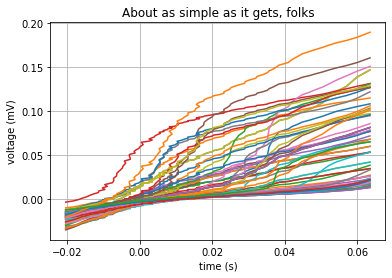

In [144]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots()
m = 21
for i in range(64):
  ax.plot(p_test[i]*255, x_test[i]*255,label=i)

ax.set(xlabel='time (s)', ylabel='voltage (mV)',
       title='About as simple as it gets, folks')
ax.grid()

# fig.savefig("test.png")
plt.show()

[-5.62218338e-05 -5.22496375e-05 -4.88885489e-05 -4.53746870e-05
 -4.30830332e-05 -4.09441600e-05 -3.91108370e-05 -3.74302981e-05
 -3.57497520e-05 -3.40692095e-05 -3.28469941e-05 -3.11664480e-05
 -3.00970132e-05 -2.88747997e-05 -2.78053631e-05 -2.65831495e-05
 -2.61248188e-05 -2.49026052e-05 -2.38331668e-05 -2.32220609e-05
 -2.21526243e-05 -2.15415166e-05 -2.04720800e-05 -1.98609723e-05
 -1.92498665e-05 -1.81804298e-05 -1.75693222e-05 -1.69582163e-05
 -1.58887779e-05 -1.52776720e-05 -1.46665643e-05 -1.42082345e-05
 -1.35971277e-05 -1.29860209e-05 -1.19165834e-05 -1.13054775e-05
 -1.06943698e-05 -1.02360400e-05 -9.62493323e-06 -9.01382555e-06
 -8.40271969e-06 -7.94438893e-06 -7.33328216e-06 -6.72217539e-06
 -6.11106861e-06 -5.65273876e-06 -5.04163199e-06 -4.43052477e-06
 -3.97219446e-06 -3.36108769e-06 -2.74998092e-06 -2.13887415e-06
 -1.68054385e-06 -1.06943708e-06 -4.58330135e-07  0.00000000e+00
  4.58330135e-07  1.06943708e-06  1.68054385e-06  2.13887415e-06
  2.74998092e-06  3.36108

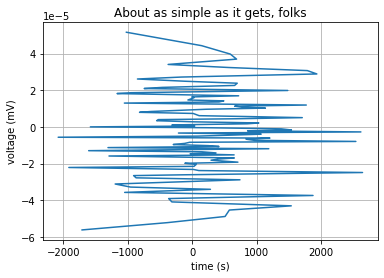

In [32]:
# We first extract the trained generator from our Conditiona GAN.
trained_gen = cond_gan.generator
(real_labels, real_pixels) = generate_real_samples(batch_size,filename = '/content/sample_test.csv')

# batch_size = tf.shape(real_pixels)[0]
random_latent_vectors = tf.random.normal(shape=(batch_size, latent_dim))
# print(random_latent_vectors[0])
random_vector_pixels = tf.concat(
    [random_latent_vectors, real_pixels], axis=1
)
print(real_labels[1])

generated_waveform = trained_gen(random_vector_pixels)

print(generated_waveform[1])
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots()
ax.plot(generated_waveform[1], real_labels[1])

ax.set(xlabel='time (s)', ylabel='voltage (mV)',
       title='About as simple as it gets, folks')
ax.grid()

# fig.savefig("test.png")
plt.show()

Here, we first sample noise from a normal distribution and then we repeat that for
`num_interpolation` times and reshape the result accordingly.
We then distribute it uniformly for `num_interpolation`
with the label indentities being present in some proportion.

In [ ]:
fake_images *= 255.0
converted_images = fake_images.astype(np.uint8)
converted_images = tf.image.resize(converted_images, (96, 96)).numpy().astype(np.uint8)
imageio.mimsave("animation.gif", converted_images, fps=1)
embed.embed_file("animation.gif")

We can further improve the performance of this model with recipes like
[WGAN-GP](https://keras.io/examples/generative/wgan_gp).
Conditional generation is also widely used in many modern image generation architectures like
[VQ-GANs](https://arxiv.org/abs/2012.09841), [DALL-E](https://openai.com/blog/dall-e/),
etc.

You can use the trained model hosted on [Hugging Face Hub](https://huggingface.co/keras-io/conditional-gan) and try the demo on [Hugging Face Spaces](https://huggingface.co/spaces/keras-io/conditional-GAN).